# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
# Read in data
Appliance_subset_df = pd.read_parquet('../Project Main/data/Appliance_file_subset.parquet', engine='pyarrow')

In [3]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,1619039933066,0,True
1,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,1485195813000,0,True
2,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,AGIOHNK7IWRDNBWYPGETIDTKTJUA,1505914496902,0,True
3,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,1605903535168,0,True
4,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,1645229528359,0,True


In [4]:
print(Appliance_subset_df.shape)

(50000, 10)


In [5]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5918
2.0     1871
3.0     2421
4.0     5024
5.0    34766
Name: count, dtype: int64

## Quick EDA

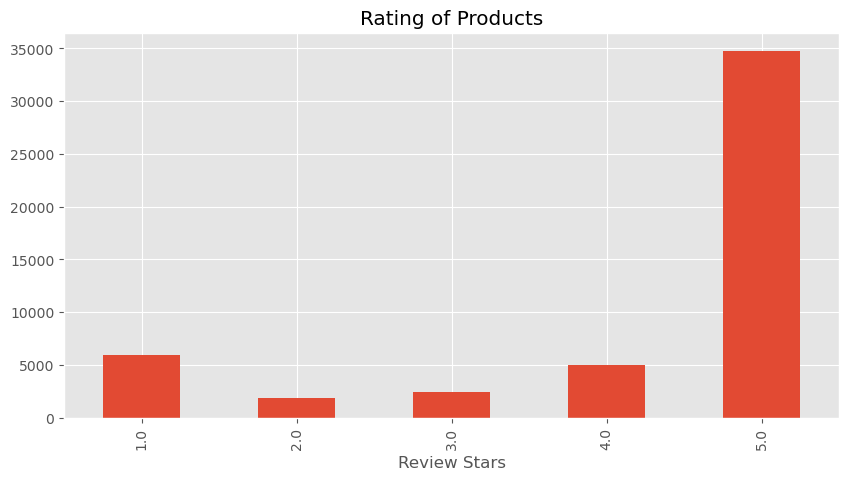

In [5]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [14]:
example = Appliance_subset_df['text'][1989]
print(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Easy',
 'Replacement',
 'Parts',
 'for',
 'Appliances',
 'at',
 'a',
 'Reduced',
 'Price',
 'and',
 'fits',
 'perfect',
 '...']

In [9]:
#part of speech tagging values
tagged = nltk.pos_tag(tokens)
tagged[:]

[('Easy', 'JJ'),
 ('Replacement', 'NNP'),
 ('Parts', 'NNP'),
 ('for', 'IN'),
 ('Appliances', 'NNP'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('Reduced', 'NNP'),
 ('Price', 'NNP'),
 ('and', 'CC'),
 ('fits', 'NNS'),
 ('perfect', 'VBP'),
 ('...', ':')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
#prettyprint

(S
  (PERSON Easy/JJ)
  (ORGANIZATION Replacement/NNP Parts/NNP)
  for/IN
  Appliances/NNP
  at/IN
  a/DT
  (ORGANIZATION Reduced/NNP)
  Price/NNP
  and/CC
  fits/NNS
  perfect/VBP
  .../:)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mike/nltk_data...


True

In [21]:

sia = SentimentIntensityAnalyzer()

In [22]:
sia

In [23]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [24]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [25]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [26]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [27]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

interesting

Should be more positive than that

In [28]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [29]:
results

{'AFJBSFUSBCMWLLXMBZ44ETHRKNOA': {'neg': 0.072,
  'neu': 0.809,
  'pos': 0.118,
  'compound': 0.3818},
 'AGB653QU2TLQPUZ2QX3VNRWFOUKQ': {'neg': 0.0,
  'neu': 0.0,
  'pos': 1.0,
  'compound': 0.6588},
 'AGIOHNK7IWRDNBWYPGETIDTKTJUA': {'neg': 0.0,
  'neu': 0.391,
  'pos': 0.609,
  'compound': 0.7774},
 'AGBTZVKIXMEBARPSYPIQLFH2NYWQ': {'neg': 0.0,
  'neu': 0.58,
  'pos': 0.42,
  'compound': 0.7003},
 'AHKS2IQWTIFWQZTUVP23U2GYLO5Q': {'neg': 0.0,
  'neu': 0.377,
  'pos': 0.623,
  'compound': 0.765},
 'AHY557OHZXZUGKRAB6ZHRONRE26A': {'neg': 0.0,
  'neu': 0.671,
  'pos': 0.329,
  'compound': 0.6597},
 'AGOICXX54S3SREXAOM3BYYN4AZRA': {'neg': 0.082,
  'neu': 0.918,
  'pos': 0.0,
  'compound': -0.395},
 'AHO74DWEGRT3UVGRKG4CCOMTL5BA': {'neg': 0.0,
  'neu': 0.734,
  'pos': 0.266,
  'compound': 0.4404},
 'AH7AGJZSWT5KAEW4OFJIH5DQCUUA': {'neg': 0.042,
  'neu': 0.863,
  'pos': 0.096,
  'compound': 0.9699},
 'AFMZ3YXI2VANHHEXF2LCBCYHFEGA': {'neg': 0.043,
  'neu': 0.803,
  'pos': 0.154,
  'compound': 

In [30]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [31]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [32]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [33]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [34]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,1619039933066,0,True
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,1485195813000,0,True
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,1505914496902,0,True
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,1605903535168,0,True
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,1645229528359,0,True


## Plot VADER results

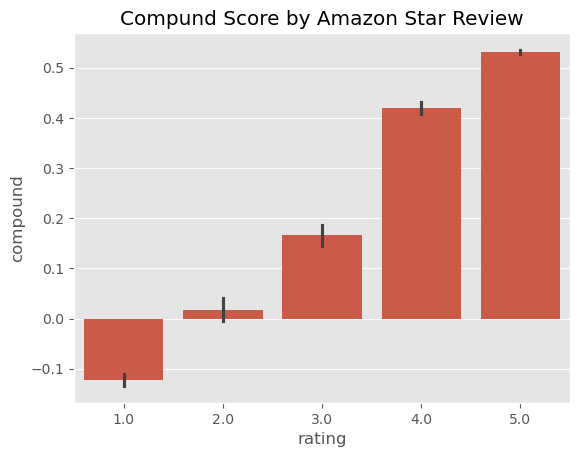

In [35]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

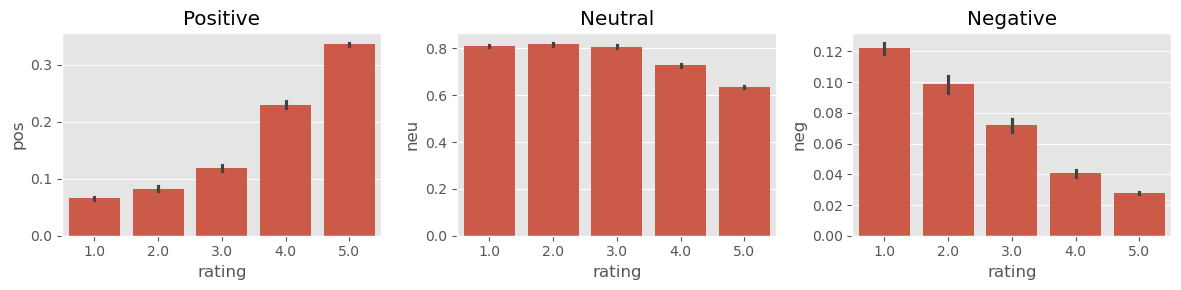

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

next step Install PyTorch

In [43]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [48]:
#pull in a model provided by hugging face pre-trained on a large twitter dataset 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [49]:
# Remembering VADER results on example
print(example)
sia.polarity_scores(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [51]:
# Run for Roberta Model (with GPU)
encoded_text = tokenizer(example, return_tensors='pt')
encoded_text = {key: value.to(device) for key, value in encoded_text.items()}
with torch.no_grad():  # Disable gradient computation for inference
    output = model(**encoded_text)
scores = output[0][0].detach().cpu().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.003501812, 'roberta_neu': 0.09521232, 'roberta_pos': 0.9012858}


In [47]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# for use without GPU
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [53]:
# for use with GPU
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    encoded_text = {key: value.to(device) for key, value in encoded_text.items()}  # Move to GPU
    with torch.no_grad():  # No need to track gradients during inference
        output = model(**encoded_text)

    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [54]:
res = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    try:
        text = row['text']
        id = row['user_id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/50000 [00:00<?, ?it/s]

Broke for id AH7AGJZSWT5KAEW4OFJIH5DQCUUA
Broke for id AEYZ5S3OU4YJPU222CDOR42FQFIA
Broke for id AEXX7CEHGXHPKKA63HPYS3JR53EQ
Broke for id AET5OZD3N6SKOSXEQMM63MH2FRSQ
Broke for id AHUTC3R7TJ54Y23QNAONOYVEOQMA
Broke for id AEANDTT6FA44G43SXM5WRBOGDPQQ
Broke for id AGQ5FX5INLXV3NGQFAYL54KKRNKA
Broke for id AG4J4PE6PIDDITVVQTTPMPZVQL7A
Broke for id AEMRRDFFGZENF3FEDGPBUH7Z4ONA
Broke for id AEYZFQNYMHIDHJ64YBLLKWRCAUKQ
Broke for id AHQUIGI6K2MJRBO7VPJF55LDLWEQ
Broke for id AELSXACGZKMH3FCYFIZXMUYMNW3A
Broke for id AEHKS5ELF23QPZKDM2JMEVGXBWAA
Broke for id AG4J7GXLW2XUZ4S6UV6CKVU53U4Q
Broke for id AFWQJPMPWMP2EFELF24P4DTVZRCA
Broke for id AH7M4M3NDYGEM575EAXTSP7TCTXQ
Broke for id AH6D7MQJELHMYVKLZ7G4CVMTU36Q
Broke for id AHCNHYYUHDQIGX5KFROEWADYRRBA
Broke for id AFY55P42FMXYL7KMAPA7YMZTLXOA
Broke for id AG262ZQWBKYDPRDKLKJ2U22IPU5A
Broke for id AH7A7XFGTWMSNDJZ2DW52MHCB3DQ
Broke for id AFPXCGOBYLDONVUJQ5UKPCHE2H3Q
Broke for id AGGX3IO2W4G7AZ2ULABQYOTREK5A
Broke for id AHW75AIIJYSMLE2CWX4LF

../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], thread: [5,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [193,0,0], 

Broke for id AHGENNE4FLT2T6RTDHW564Y4TBXQ
Broke for id AFGQSHPJJN5ZPSS5IUELGGREWKNQ
Broke for id AH3VR7MORI7463SW7HBA5M6AVW3A
Broke for id AE4RFFHWOGTCFOLXUVHIHGCZPZYA
Broke for id AH4QXFPO3P5ASIYKKP6ESM4OJF4Q
Broke for id AGGHELCK6AYJ2LAQHZFP2FVXSJRQ
Broke for id AHU5HQA6DJOZ7R5YYBUNFIZ747FA
Broke for id AFKYN6257Z4WXS2ZHAE2N5ENJQGA
Broke for id AHIEYRJQ4JRWYO7NJRS5RUUSRMJQ
Broke for id AFXIUZTKJTSI6SOR4VGDQMI5FFZQ
Broke for id AE7FDFUY24RZ5KLKIADZ55ZIOEJQ
Broke for id AHDGUNF2XUORBNKFHLKUVBWFKFZA
Broke for id AGDVXM3JBPODOWMN456GAHERQXAA
Broke for id AHMAPMBA2J6VZDD2VBJVHTEPRIWQ
Broke for id AEHGXGC4RTLRBSLQX52VICSNJHYA
Broke for id AG4GZFTMZWZHFUIKIAQ72B6AC7GQ
Broke for id AGCWQITIZZG3VEDJOAON5PVS6B4Q
Broke for id AFFUQYAB7HYHGQF2YFQDIQOATAEQ
Broke for id AHIXXH6OVUGMJBGZSQR3G4YZ5PLA
Broke for id AF2G6RLXVG7LLIMHVGJUC7ZIKYVA
Broke for id AHC767ILLEF6QNNWCTMFNAITNFBQ
Broke for id AEBZKGSDYM7BTN36VDG34SMCVIOA
Broke for id AHUI7C3UKGKZGNU6URVRXXUDJKDQ
Broke for id AHOEHESXARRYMHP5YSG2S

In [55]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

NameError: name 'df' is not defined

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [29]:
# negative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# __